In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Paths
train_dir = "dataset/train"
val_dir = "dataset/val"
test_dir = "dataset/test"

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 25

In [3]:
# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,         
    width_shift_range=0.1,       
    height_shift_range=0.1,      
    zoom_range=0.2,
    shear_range=0.15,            
    horizontal_flip=True,
    fill_mode='nearest'          
)

# No augmentation for validation and test, only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 5537 images belonging to 2 classes.
Found 1186 images belonging to 2 classes.
Found 1188 images belonging to 2 classes.


In [4]:
# Class Weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_generator.classes),
                                     y=train_generator.classes)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.594758064516129, 1: 0.7283609576427256}


In [5]:
# Load DenseNet121 without top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base model layers

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

2025-04-24 01:21:53.903229: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-24 01:21:53.903540: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-24 01:21:53.903547: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-24 01:21:53.903742: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-24 01:21:53.903766: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [6]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("densenet_model.keras", save_best_only=True, verbose=1)
]


In [6]:

# Train
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    class_weight=class_weights,
                    callbacks=callbacks)

/opt/homebrew/Caskroom/miniforge/base/envs/cnn-env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


2025-04-23 23:14:29.116269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.5341 - loss: 1.0587  
Epoch 1: val_loss improved from inf to 0.52557, saving model to densenet_model.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 121s 659ms/step - accuracy: 0.5342 - loss: 1.0584 - val_accuracy: 0.7538 - val_loss: 0.5256
Epoch 2/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.5928 - loss: 0.9234  
Epoch 2: val_loss improved from 0.52557 to 0.49139, saving model to densenet_model.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 114s 651ms/step - accuracy: 0.5928 - loss: 0.9234 - val_accuracy: 0.8019 - val_loss: 0.4914
Epoch 3/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.6249 - loss: 0.8572  
Epoch 3: val_loss improved from 0.49139 to 0.48005, saving model to densenet_model.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 122s 697ms/step - accuracy: 0.6249 - loss: 0.8571 - val_accuracy: 0.8002 - val_loss: 0.4801
Epoch 4/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.6299 - loss: 0.8221  
Epoch 4: val_loss improve

In [7]:
# Fine-tune
model = load_model("densenet_model.keras")
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 30
history_fine = model.fit(train_generator,
                         validation_data=val_generator,
                         epochs=fine_tune_epochs,
                         class_weight=class_weights,
                         callbacks=callbacks)

/opt/homebrew/Caskroom/miniforge/base/envs/cnn-env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


2025-04-24 01:21:59.693504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.7008 - loss: 0.7022  
Epoch 1: val_loss improved from inf to 0.40281, saving model to densenet_model.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 121s 654ms/step - accuracy: 0.7008 - loss: 0.7022 - val_accuracy: 0.8474 - val_loss: 0.4028
Epoch 2/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.7039 - loss: 0.6787  
Epoch 2: val_loss improved from 0.40281 to 0.40280, saving model to densenet_model.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 118s 676ms/step - accuracy: 0.7039 - loss: 0.6786 - val_accuracy: 0.8465 - val_loss: 0.4028
Epoch 3/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.7103 - loss: 0.6683  
Epoch 3: val_loss improved from 0.40280 to 0.40183, saving model to densenet_model.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 132s 758ms/step - accuracy: 0.7102 - loss: 0.6685 - val_accuracy: 0.8482 - val_loss: 0.4018
Epoch 4/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.7132 - loss: 0.6709  
Epoch 4: val_loss improve

In [8]:
# Evaluate on Test
test_generator.reset()
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype("int32")
y_true = test_generator.classes

# Accuracy
test_acc = np.mean(y_pred.flatten() == y_true)
print(f"Test Accuracy: {test_acc:.4f}")

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step
Test Accuracy: 0.8241



Classification Report:
              precision    recall  f1-score   support

      Benign       0.72      0.72      0.72       373
   Malignant       0.87      0.87      0.87       815

    accuracy                           0.82      1188
   macro avg       0.80      0.80      0.80      1188
weighted avg       0.82      0.82      0.82      1188

Confusion Matrix:
[[268 105]
 [104 711]]


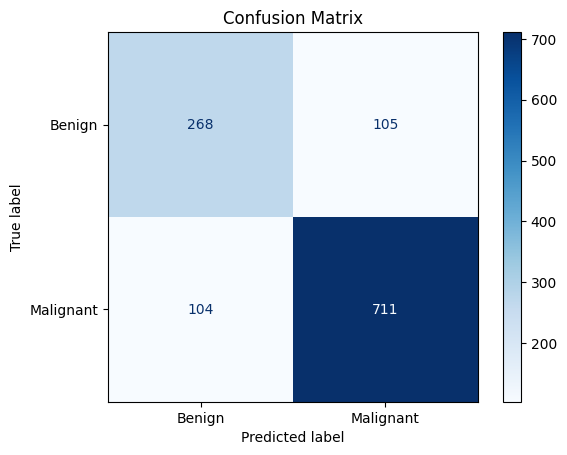

In [9]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

cm = confusion_matrix(y_true, y_pred)
# Confusion Matrix
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

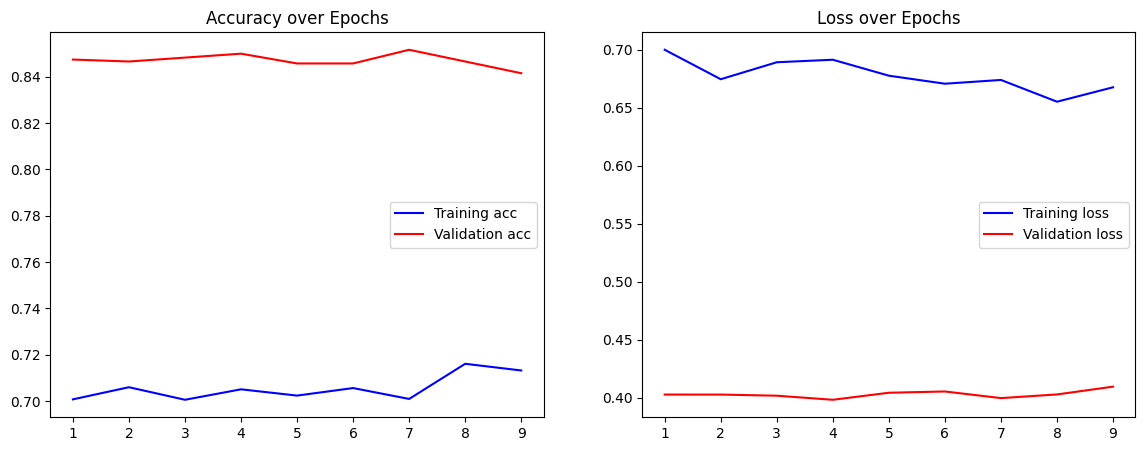

In [11]:
# Plot training
def plot_history(h1):
    acc = h1.history['accuracy']
    val_acc = h1.history['val_accuracy']
    loss = h1.history['loss']
    val_loss = h1.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training acc')
    plt.plot(epochs, val_acc, 'r-', label='Validation acc')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.show()

plot_history(history_fine)

In [12]:
model.save("final_densenet_model.keras")